In [12]:
import re
import random

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torch.optim import *

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from IPython.display import display, clear_output

from nltk.tokenize.treebank import TreebankWordDetokenizer

from datasets import load_dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import wandb

In [2]:
DEVICE = 'cuda'
MAXLEN = 100
EPOCHS = 50
BS = 16
LR = 1e-5

N_EMBED = 128
N_LAYERS = 2
N_HIDDEN = 256
DROPOUT_RATE = 0.2

special_tokens = {'bos_token': '|BOS|', 
                  'pad_token': '|PAD|', 
                  'eos_token': '|EOS|',
                  'unk_token': '|UNK|'}


In [3]:
def create_sentence_pairs(x):
    sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]
    
    sentence_pairs = []
    for sent1, sent2 in zip(sentences[:-1], sentences[1:]):
        sent_pair = ' '.join([special_tokens['bos_token'], sent1, 
                              special_tokens['pad_token'], sent2])
        
        sent = [tok for tok in tokenizer(sent_pair)]   #if tok in glove.stoi
        sent = sent[:MAXLEN]
        sent = sent + [special_tokens['eos_token']] * (MAXLEN - len(sent))
        sentence_pairs.append(sent)
        
    return {'sentence_pairs': sentence_pairs}

tokenizer = get_tokenizer('spacy')

train_dataset = load_dataset('knkarthick/dialogsum', split='train')
val_dataset = load_dataset('knkarthick/dialogsum', split='validation')

/home/sefa/anaconda3/envs/chat2learn/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


In [4]:
## vocab from iterator
sentence_pairs = train_dataset.map(create_sentence_pairs)['sentence_pairs']
flatten_tokens = [sent for sents in sentence_pairs for sent in sents]
vocab = build_vocab_from_iterator(flatten_tokens, min_freq=5, specials=list(special_tokens.values()))
vocab.set_default_index(vocab['|UNK|'])

del sentence_pairs
del flatten_tokens

  0%|          | 0/12460 [00:00<?, ?ex/s]

In [5]:
torch.save(vocab, 'lstm_chkpt/lstm_tokenizer.pth')

In [6]:
class LMDataset(Dataset):
    def __init__(self, dataset):
        super(LMDataset, self).__init__()

        sentence_pairs = dataset.map(create_sentence_pairs)['sentence_pairs']
        flatten_tokens = [sent for sents in sentence_pairs for sent in sents]
        
        del sentence_pairs
        
        self.tokens = torch.zeros((len(flatten_tokens), MAXLEN), dtype=torch.long, device=DEVICE)
        for i, sent in enumerate(flatten_tokens):
            self.tokens[i, :] = torch.tensor(vocab(sent))
                            
        del flatten_tokens
        
    def __getitem__(self, i):
        return self.tokens[i]

    def __len__(self):
        return len(self.tokens)


In [7]:
lm_train = LMDataset(train_dataset)
lm_valid = LMDataset(val_dataset)

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [8]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, n_layers=32, n_hidden=128):
        super(LanguageModel, self).__init__()
                
        self.embed = nn.Embedding(vocab_size, embedding_dim=embed_dim)
        self.lstm = nn.LSTM(self.embed.embedding_dim, n_hidden, num_layers=n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(n_hidden, vocab_size)
        
        self.dropout = nn.Dropout(DROPOUT_RATE)
        
    def forward(self, x, states=None):
        embeddings = self.dropout(self.embed(x))        
        out, states = self.lstm(embeddings, states)
        
        #out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.fc(out)
        
        return out, states


In [10]:
def train_step(model, loader):
    pbar = tqdm(loader, position=0, leave=False)
    batch_losses = []
    model.train()
    
    for i, batch in enumerate(pbar):
        batch = batch.to(DEVICE)

        states = (torch.zeros((N_LAYERS, batch.size(0), N_HIDDEN), device=DEVICE), 
                  torch.zeros((N_LAYERS, batch.size(0), N_HIDDEN), device=DEVICE))
        
        optimizer.zero_grad()
        states = [state.detach() for state in states]
        y_pred, states = model(batch[:, :-1], states)
        loss = criterion(y_pred.moveaxis(1, -1), batch[:, 1:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        batch_losses.append(loss.item())
        #pbar.set_description(f'Batch Loss: {loss.item():.3f} Train Loss: {np.mean(batch_losses):.3f}')
        
    return np.mean(batch_losses)


def eval_step(model, loader):
    model.eval()
    
    pbar = tqdm(loader, position=0, leave=False)
    batch_losses = []

    for i, batch in enumerate(pbar):
        batch = batch.to(DEVICE)

        y_pred, _ = model(batch[:, :-1])
        loss = criterion(y_pred.moveaxis(1, -1), batch[:, 1:])
        
        batch_losses.append(loss.item())
        #pbar.set_description(f'Batch Loss: {loss.item():.3f} Validation Loss: {np.mean(batch_losses):.3f}')
        
    return np.mean(batch_losses)


def answer(model, sent):
    model.eval()
    
    detokenizer = TreebankWordDetokenizer()
    
    sent = ' '.join([special_tokens['bos_token'], sent, special_tokens['pad_token']])
    sent = vocab(tokenizer(sent))
    sent = torch.tensor(sent, device=DEVICE)

    with torch.no_grad():
        y_pred, states = model(sent)

        pred_tokens = y_pred.argmax(dim=-1, keepdim=True)
        sent_preds = vocab.lookup_tokens(list(pred_tokens))

        answer = []
        for j in range(MAXLEN - len(sent)):
            last_idx = pred_tokens[-1]
            answer.append(vocab.lookup_token(last_idx))

            if answer[-1] == special_tokens['eos_token']:
                break

            y_pred, states = model(last_idx, states)
            pred_tokens = y_pred.argmax(dim=-1, keepdim=True)
        
        
        return detokenizer.detokenize(answer)


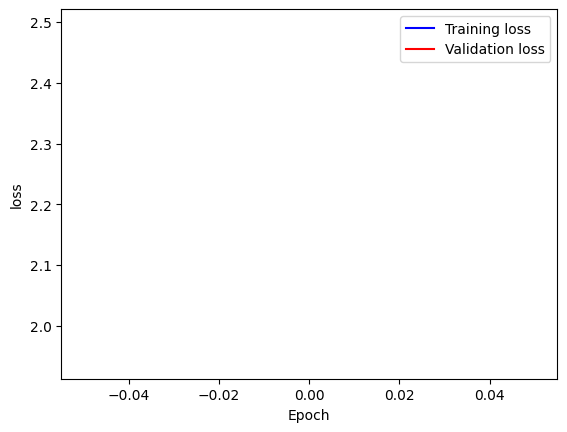

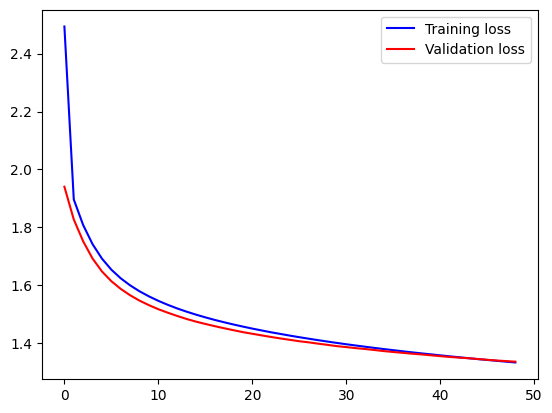

  0%|          | 0/6615 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

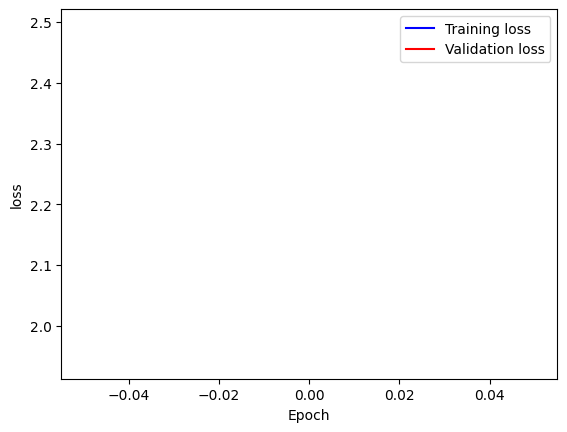

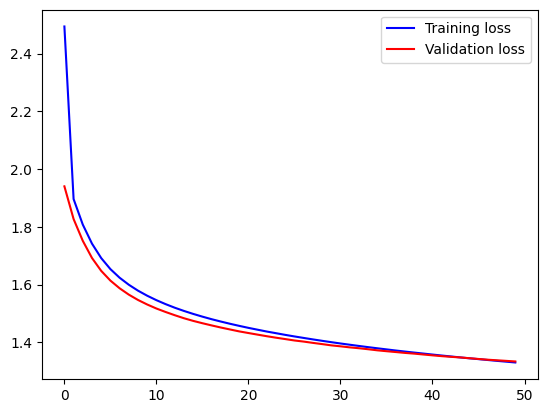

In [14]:
train_loader = DataLoader(lm_train, batch_size=BS, shuffle=True)
val_loader = DataLoader(lm_valid, batch_size=BS, shuffle=True)

model = LanguageModel(len(vocab), embed_dim=N_EMBED, n_layers=N_LAYERS, n_hidden=N_HIDDEN).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

fig, (ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')

for epoch in range(EPOCHS):
    ## training
    train_loss = train_step(model, train_loader)
    val_loss = eval_step(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch != EPOCHS -1:
        clear_output(wait=True)

    plt.plot(train_losses, 'b', label='Training loss')
    plt.plot(val_losses, 'r', label='Validation loss')
    plt.legend()

    display(fig)
    plt.pause(0.5)
    
# save the model after training
torch.save(model, f'lstm_chkpt/lstm_model.pt')        


In [ ]:
import matplotlib.pyplot as plt

tlosses = trials[0]['train_losses']
vlosses = trials[0]['val_losses']

fig, (ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')

my_t, my_v = [], []
for t, v in zip(tlosses, vlosses):
    my_t.append(t)
    my_v.append(v)
    plt.plot(my_t, 'b', label='Training loss')
    plt.plot(my_v, 'r', label='Validation Loss')
    plt.legend()
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)

In [15]:
val_losses[-1]


1.333923578262329